In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py


D:\Anaconda3\envs\pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
# Import FBP
sys.path.append('../FBPConvNet/')
from FBPConvNet import Generator, Discriminator

sys.path.append('../')
from net_utils import get_datetime

# Generate Example Data

In [4]:
def preprocess(data):
    return torch.Tensor(data).unsqueeze(1)
def target_ones(N,gpu=False):
    if GPU:
        return torch.ones(N,1).cuda()
    else:
        return torch.ones(N,1)
def target_zeros(N,gpu=False):
    if GPU:
        return torch.zeros(N,1).cuda()
    else:
        return torch.zeros(N,1)   

In [5]:
# set path to data
pathtodata = '../EllipseGeneration/RandomLineEllipses15.hdf5'
dataset_size = 200
batch_size = 1

In [6]:
f = h5py.File(pathtodata,'r')
print([ key for key in f['ellip']])
fakeinput = preprocess(f['ellip/training_data'][0:dataset_size])
fakelabels = preprocess(f['ellip/training_labels'][0:dataset_size])
# reallabels = preprocess(f['ellip/training_labels'][dataset_size:2*dataset_size])

testinput = preprocess(f['ellip/test_data'])
testlabels = preprocess(f['ellip/test_labels'])
f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


In [84]:
# f = h5py.File(pathtodata,'r')
# print([ key for key in f['ellip']])

# fakeinput1 = f['ellip/training_data'][0:dataset_size]
# fakeinput2 = fakeinput1.copy()[:,:,::-1]
# fakeinput = preprocess(np.concatenate((fakeinput1,fakeinput2)))

# fakelabels1 = f['ellip/training_labels'][0:dataset_size]
# fakelabels2 = fakelabels1.copy()[:,:,::-1]
# fakelabels = preprocess(np.concatenate((fakelabels1,fakelabels2)))

# reallabels1 = f['ellip/training_labels'][dataset_size:2*dataset_size]
# reallabels2 = reallabels1.copy()[:,:,::-1]
# reallabels = preprocess(np.concatenate((reallabels1,reallabels2)))

# del fakeinput1, fakeinput2, fakelabels1, fakelabels2, reallabels1, reallabels2

# # testinput = preprocess(f['ellip/test_data'])
# # testlabels = preprocess(f['ellip/test_labels'])
# f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


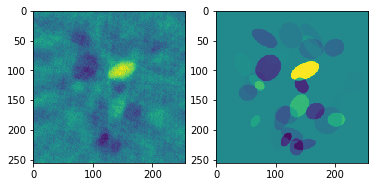

In [87]:
plt.figure()
plt.subplot(121)
plt.imshow(fakeinput[-1,0])
plt.subplot(122)
plt.imshow(fakelabels[-1,0])

In [7]:
faketrainset = TensorDataset(fakeinput,fakelabels)
testset = TensorDataset(testinput,testlabels)

faketrainloader = DataLoader(faketrainset,batch_size=batch_size,shuffle=True)
# realtrainloader = DataLoader(reallabels, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=1,shuffle=False)

# Plot Training Loss

In [42]:
basepath = './experiments/8_GANs_newG/'

In [ ]:
# Epoch	D Loss	G Loss	Epoch Time	Total Time

In [43]:
loss = np.loadtxt(basepath+'log.txt',skiprows=1,usecols=(0,1,2), delimiter='\t' ,dtype=float)

In [44]:
d_losses = loss[:,1]
g_losses = loss[:,2]

Text(0.5,1,'Generator Losses')

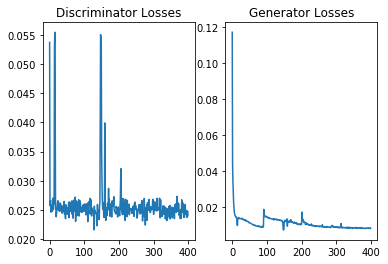

In [45]:
start = 0
end = 400#len(d_losses)
plt.figure()
plt.subplot(121)
plt.plot(np.arange(start,end),d_losses[start:end])
plt.title('Discriminator Losses')
plt.subplot(122)
plt.plot(np.arange(start,end),g_losses[start:end])
plt.title('Generator Losses')

# Visualize Examples

In [46]:
G = Generator()
GPU = torch.cuda.is_available()
print('Using GPU:',GPU)

Using GPU: True


In [47]:
#weightspath = '../FBPConvNet/weights/2018-05-07_14-50-41/epoch_500.weights'
#basepath = './experiments/6_GANs_AugmentedData/'
weightspath = basepath+'G_epoch_500.weights'
print(weightspath)
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
if GPU:
    G = G.cuda()

./experiments/8_GANs_newG/G_epoch_500.weights


In [49]:
testiter = iter(testloader)

(-0.5, 255.5, 255.5, -0.5)

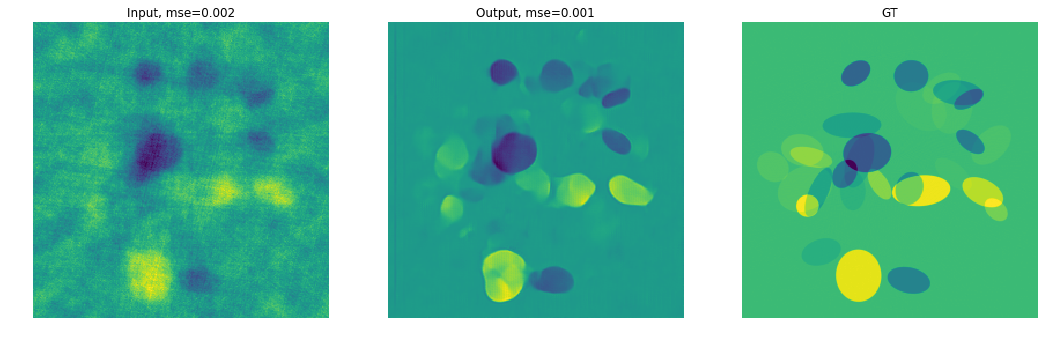

In [63]:
y,x = testiter.next()
G.train()
GPU = True
if GPU:
    xhat = G(Variable(y.cuda(),volatile=True))
    xhat = xhat.cpu().data
else:
    xhat = G(Variable(y)).data
plt.figure(figsize=(18,6))
plt.subplot(131)
mse =torch.mean((y[0,0,:,:]-x[0,0,:,:])**2)
plt.imshow(y[0,0,...].numpy())
plt.title('Input, mse=%.3f'%(mse))
plt.axis('off')

mse =torch.mean((xhat[0,0,:,:]-x[0,0,:,:])**2)
plt.subplot(132)
plt.imshow(xhat[0,0,...].numpy())
plt.title('Output, mse=%.3f'%(mse))
plt.axis('off')

plt.subplot(133)
plt.imshow(x[0,0,...].numpy())
plt.title('GT')
plt.axis('off')

# Compute Average MSE

In [64]:
def test_mse(G, testloader):
    # Calculate Test MSE
    test_mses = np.zeros(len(testloader))
    for i,data in enumerate(testloader):
        y,x = data 
        GPU = True
        if GPU:
            xhat = G(Variable(y.cuda(),volatile=True))
            xhat = xhat.cpu().data
        else:
            xhat = G(Variable(y,volatile=True)).data

        test_mses[i] = torch.mean((xhat[:,0,:,:]-x[:,0,:,:])**2)
    return test_mses.mean()

In [180]:
mse = test_mse(G,testloader)
print('Test MSE = %f'%(mse))

Test MSE = 0.001427


In [65]:
nums = range(0,500,25)
len(nums), nums[-1]

(20, 475)

In [68]:
mses = np.zeros(len(nums)+1)
train_mses = np.zeros(len(nums)+1)

G_basepath = basepath + 'G_epoch_'

for i,epoch in enumerate(nums):
    weightspath = G_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    G.load_state_dict(checkpoint)
    G = G.cuda()
    mses[i] = test_mse(G,testloader)
    train_mses[i] = test_mse(G,faketrainloader)

weightspath = G_basepath + str(500) + '.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
G = G.cuda()
mses[-1] = test_mse(G,testloader)
train_mses[-1] = test_mse(G,faketrainloader)

plt.figure()
#plt.plot(nums,mses)
epochs = range(0,501,25)
plt.plot(epochs,mses,label='Test MSE')
plt.plot(epochs,mses,label='Train MSE')
plt.legend(loc=0)

print('Test:',mses[-1],mses.min())
print('Train:',train_mses[-1],train_mses.min())

0.0006769356291435353 0.00041860749375219287


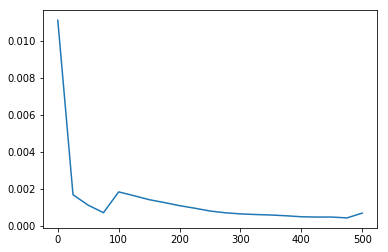

In [69]:
G_basepath = basepath + 'G_epoch_'

for i,epoch in enumerate(nums):
    weightspath = G_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    G.load_state_dict(checkpoint)
    G = G.cuda()
weightspath = G_basepath + str(500) + '.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
G = G.cuda()

#plt.plot(nums,mses)
plt.plot(range(0,501,25),train_mses)
print(train_mses[-1],train_mses.min())

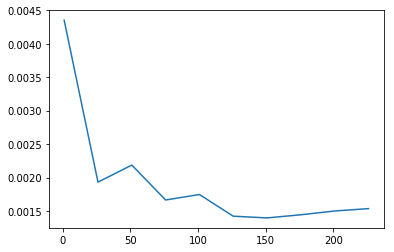

In [135]:
plt.plot(np.arange(1,227,25),mses)

In [96]:
print(mses[-1], mses.min())

0.0015492109404315864 0.001338506935090303


In [97]:
test_mses = np.zeros(len(testloader))

for i,data in enumerate(testloader):
    y,x = data 

    test_mses[i] = torch.mean((y[:,0,:,:]-x[:,0,:,:])**2)
print(test_mses.mean())

0.002872662238750937


In [ ]:
G = G.cpu()
torch.save(G.state_dict(),'Gmse_100.weights')
D = D.cpu()
torch.save(D.state_dict(),'Dmse_100.weights')

if GPU:
    G = G.cuda()
    D = D.cuda()
